In [1]:
## UofT SCS FinTech Bootcamp Project 1 Team Code
## Project team: Ambreen Simon, George Barbuc, Katie Gouinlock, Keiran Gugula
# Import libraries required for analysis and visualization
from pathlib import Path
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import datetime as dt
import yfinance as yf
import random
from MCForecastTools import MCSimulation

%matplotlib inline


Bad key savefig.frameon in file C:\Users\George\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file C:\Users\George\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file C:\Users\George\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You pro

In [2]:
# Create dataframe with S&P 500 tickers based on information in CSV file
sp_csv = pd.read_csv(Path("sp500.csv"))

In [3]:
# Keiran can you confirm what this step does ?
tickers = [x for x in sp_csv.loc[:, "Symbol"]]

# Appending SPY ticker to S&P 500 consitutents. SPY will be used as a proxy for S&P 500 returns
tickers.append("SPY")

# Downloading historical price data for S&P 500 securities using Yfinance library
data = yf.download(tickers=tickers, start="2012-01-01", end="2017-01-01", group_by="ticker")

[*********************100%***********************]  506 of 506 completed

12 Failed downloads:
- VIAC: Data doesn't exist for startDate = 1325394000, endDate = 1483246800
- BRK.B: No data found, symbol may be delisted
- FOX: Data doesn't exist for startDate = 1325394000, endDate = 1483246800
- CARR: Data doesn't exist for startDate = 1325394000, endDate = 1483246800
- NLOK: No data found for this date range, symbol may be delisted
- FOXA: Data doesn't exist for startDate = 1325394000, endDate = 1483246800
- OTIS: Data doesn't exist for startDate = 1325394000, endDate = 1483246800
- BF.B: No data found for this date range, symbol may be delisted
- CTVA: Data doesn't exist for startDate = 1325394000, endDate = 1483246800
- IR: Data doesn't exist for startDate = 1325394000, endDate = 1483246800
- HWM: No data found for this date range, symbol may be delisted
- DOW: Data doesn't exist for startDate = 1325394000, endDate = 1483246800


In [4]:
data.head()

SYF                                        AXP             \
           Open High Low Close Adj Close Volume       Open       High   
Date                                                                    
2012-01-03  NaN  NaN NaN   NaN       NaN    NaN  48.299999  48.959999   
2012-01-04  NaN  NaN NaN   NaN       NaN    NaN  48.020000  48.380001   
2012-01-05  NaN  NaN NaN   NaN       NaN    NaN  47.840000  49.250000   
2012-01-06  NaN  NaN NaN   NaN       NaN    NaN  48.869999  48.970001   
2012-01-09  NaN  NaN NaN   NaN       NaN    NaN  48.320000  48.700001   

                                  ...        DPZ                        \
                  Low      Close  ...        Low      Close  Adj Close   
Date                              ...                                    
2012-01-03  48.139999  48.389999  ...  33.090000  33.150002  28.242994   
2012-01-04  47.400002  48.240002  ...  33.099998  33.820000  28.813814   
2012-01-05  47.700001  48.799999  ...  33.029999  33.369999  28.430439   
2012-01-06  48.049999  48.270000  ...  33.130001  33.299999  28.370794   
2012-01-09  48.119999  48.389999  ...  33.330002  33.570000  28.600832   

                             TT                                              \
              Volume       Open       High        Low      Close  Adj Close   
Date                                                                          
2012-01-03  797200.0  19.357700  19.989738  19.357700  19.890596  16.972301   
2012-01-04  450500.0  19.803844  20.026917  19.599363  19.741880  16.845406   
2012-01-05  623500.0  19.679916  20.070293  19.450647  19.964952  17.035748   
2012-01-06  724400.0  20.070293  20.181829  19.816238  19.841024  16.930002   
2012-01-09  566200.0  19.915380  20.200418  19.661327  20.107471  17.157354   

                       
               Volume  
Date                   
2012-01-03  5200200.0  
2012-01-04  3785100.0  
2012-01-05  4396700.0  
2012-01-06  3901600.0  
2012-01-09  3191500.0  

[5 rows x 3036 columns]

In [5]:
# Creating function in order to clean data downloaded from yfinance library
# Cleaning data requires dropping all columns other than close price, and then returning the resulting data frame
def clean_yahoo_df(data):
    data.drop(["Open", "High", "Low", "Adj Close", "Volume"], axis=1, level=1, inplace=True)
    df_clean = data.droplevel(axis=1, level=1)
    return df_clean
    
sp_df_clean = clean_yahoo_df(data)
sp_df_clean.head()

,SYF,AXP,DTE,AJG,UPS,EXPE,LKQ,AAL,MNST,FMC,...,SYK,AZO,IEX,ALXN,MAR,IVZ,SLG,NBL,DPZ,TT
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,NaN,48.389999,53.869999,33.290001,74.160004,29.660000,15.390,5.12,15.416667,37.961838,...,51.070000,319.790009,37.299999,70.570000,30.000000,20.559999,68.160004,48.880001,33.150002,19.890596
2012-01-04,NaN,48.240002,53.599998,32.759998,73.839996,29.030001,15.480,5.03,15.431666,37.888119,...,51.250000,326.959991,37.410000,70.290001,30.469999,20.350000,68.190002,49.290001,33.820000,19.741880
2012-01-05,NaN,48.799999,53.990002,32.840000,73.120003,28.770000,15.800,5.47,15.643333,37.705986,...,51.189999,333.850006,38.090000,72.410004,31.469999,20.570000,69.440002,48.750000,33.369999,19.964952
2012-01-06,NaN,48.270000,53.520000,32.910000,73.480003,29.250000,15.615,5.60,15.896667,38.148308,...,51.500000,338.040009,38.000000,74.449997,31.740000,20.770000,69.779999,48.360001,33.299999,19.841024
2012-01-09,NaN,48.389999,53.520000,32.959999,73.449997,28.629999,15.655,5.72,15.986667,38.148308,...,51.799999,339.500000,38.090000,74.269997,32.169998,20.889999,69.529999,49.165001,33.570000,20.107471


In [6]:
# Storing cleaned data from yfinance to a new dataframe
sp_df_clean.to_csv("sp500_raw_data.csv")

In [7]:
# Creating a new dataframe from the cleaned yfinance S&P 500 data, setting index as the date
sp_path = Path("sp500_raw_data.csv")
sp_combined_df = pd.read_csv(sp_path, index_col='Date',infer_datetime_format=True,parse_dates=True)
sp_combined_df.head(5)

,SYF,AXP,DTE,AJG,UPS,EXPE,LKQ,AAL,MNST,FMC,...,SYK,AZO,IEX,ALXN,MAR,IVZ,SLG,NBL,DPZ,TT
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,NaN,48.389999,53.869999,33.290001,74.160004,29.660000,15.390,5.12,15.416667,37.961838,...,51.070000,319.790009,37.299999,70.570000,30.000000,20.559999,68.160004,48.880001,33.150002,19.890596
2012-01-04,NaN,48.240002,53.599998,32.759998,73.839996,29.030001,15.480,5.03,15.431666,37.888119,...,51.250000,326.959991,37.410000,70.290001,30.469999,20.350000,68.190002,49.290001,33.820000,19.741880
2012-01-05,NaN,48.799999,53.990002,32.840000,73.120003,28.770000,15.800,5.47,15.643333,37.705986,...,51.189999,333.850006,38.090000,72.410004,31.469999,20.570000,69.440002,48.750000,33.369999,19.964952
2012-01-06,NaN,48.270000,53.520000,32.910000,73.480003,29.250000,15.615,5.60,15.896667,38.148308,...,51.500000,338.040009,38.000000,74.449997,31.740000,20.770000,69.779999,48.360001,33.299999,19.841024
2012-01-09,NaN,48.389999,53.520000,32.959999,73.449997,28.629999,15.655,5.72,15.986667,38.148308,...,51.799999,339.500000,38.090000,74.269997,32.169998,20.889999,69.529999,49.165001,33.570000,20.107471


In [8]:
## Commencing data cleaning procedures
# Check to confirm whether there are any duplicates in the index variable
sp_combined_df.duplicated()

Date
2012-01-03    False
2012-01-04    False
2012-01-05    False
2012-01-06    False
2012-01-09    False
2012-01-10    False
2012-01-11    False
2012-01-12    False
2012-01-13    False
2012-01-17    False
2012-01-18    False
2012-01-19    False
2012-01-20    False
2012-01-23    False
2012-01-24    False
2012-01-25    False
2012-01-26    False
2012-01-27    False
2012-01-30    False
2012-01-31    False
2012-02-01    False
2012-02-02    False
2012-02-03    False
2012-02-06    False
2012-02-07    False
2012-02-08    False
2012-02-09    False
2012-02-10    False
2012-02-13    False
2012-02-14    False
              ...  
2016-11-17    False
2016-11-18    False
2016-11-21    False
2016-11-22    False
2016-11-23    False
2016-11-25    False
2016-11-28    False
2016-11-29    False
2016-11-30    False
2016-12-01    False
2016-12-02    False
2016-12-05    False
2016-12-06    False
2016-12-07    False
2016-12-08    False
2016-12-09    False
2016-12-12    False
2016-12-13    False
2016-12-14    F

In [9]:
# Writing data to a csv file for future use
sp_combined_df.to_csv("sp500_clean.csv")

In [10]:
# Reading in data from csv file and continuing cleaning procedures, beginning first with visualizing data
sp_csv_clean = pd.read_csv(Path("sp500_clean.csv"),index_col='Date',infer_datetime_format=True,parse_dates=True)
sp_csv_clean.head()

,SYF,AXP,DTE,AJG,UPS,EXPE,LKQ,AAL,MNST,FMC,...,SYK,AZO,IEX,ALXN,MAR,IVZ,SLG,NBL,DPZ,TT
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,NaN,48.389999,53.869999,33.290001,74.160004,29.660000,15.390,5.12,15.416667,37.961838,...,51.070000,319.790009,37.299999,70.570000,30.000000,20.559999,68.160004,48.880001,33.150002,19.890596
2012-01-04,NaN,48.240002,53.599998,32.759998,73.839996,29.030001,15.480,5.03,15.431666,37.888119,...,51.250000,326.959991,37.410000,70.290001,30.469999,20.350000,68.190002,49.290001,33.820000,19.741880
2012-01-05,NaN,48.799999,53.990002,32.840000,73.120003,28.770000,15.800,5.47,15.643333,37.705986,...,51.189999,333.850006,38.090000,72.410004,31.469999,20.570000,69.440002,48.750000,33.369999,19.964952
2012-01-06,NaN,48.270000,53.520000,32.910000,73.480003,29.250000,15.615,5.60,15.896667,38.148308,...,51.500000,338.040009,38.000000,74.449997,31.740000,20.770000,69.779999,48.360001,33.299999,19.841024
2012-01-09,NaN,48.389999,53.520000,32.959999,73.449997,28.629999,15.655,5.72,15.986667,38.148308,...,51.799999,339.500000,38.090000,74.269997,32.169998,20.889999,69.529999,49.165001,33.570000,20.107471


In [11]:
# Confirming number of entries in data frame
sp_csv_clean.shape

(1260, 506)

In [12]:
# Checking for null values
sp_csv_clean.isnull().sum()

SYF       649
AXP         2
DTE         2
AJG         2
UPS         2
EXPE        2
LKQ         2
AAL         2
MNST        2
FMC         2
CTSH        2
STE         2
CTAS        2
CTL         2
WLTW        2
HBAN        2
UNM         2
HSIC        2
IQV       340
CTXS        2
ZION        2
EL          2
AIZ         2
ODFL        2
FE          2
VIAC     1260
SRE         2
CINF        2
PXD         2
MKTX        2
         ... 
MSFT        2
FCX         2
DD          2
T           2
SO          2
IDXX        2
BSX         2
ETN         2
WRK       875
WST         2
AMT         2
PNR         2
XRX         2
HCA         2
GWW         2
ABBV      252
ETR         2
DVN         2
KHC       882
CMCSA       2
SYK         2
AZO         2
IEX         2
ALXN        2
MAR         2
IVZ         2
SLG         2
NBL         2
DPZ         2
TT          2
Length: 506, dtype: int64

In [13]:
# Further exploring data frame in preparation for cleaning of data
sp_csv_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1260 entries, 2012-01-03 to 2016-12-30
Columns: 506 entries, SYF to TT
dtypes: float64(506)
memory usage: 4.9 MB


In [14]:
# Confirming data types in dataframe are all float values
sp_csv_clean.dtypes

SYF      float64
AXP      float64
DTE      float64
AJG      float64
UPS      float64
EXPE     float64
LKQ      float64
AAL      float64
MNST     float64
FMC      float64
CTSH     float64
STE      float64
CTAS     float64
CTL      float64
WLTW     float64
HBAN     float64
UNM      float64
HSIC     float64
IQV      float64
CTXS     float64
ZION     float64
EL       float64
AIZ      float64
ODFL     float64
FE       float64
VIAC     float64
SRE      float64
CINF     float64
PXD      float64
MKTX     float64
          ...   
MSFT     float64
FCX      float64
DD       float64
T        float64
SO       float64
IDXX     float64
BSX      float64
ETN      float64
WRK      float64
WST      float64
AMT      float64
PNR      float64
XRX      float64
HCA      float64
GWW      float64
ABBV     float64
ETR      float64
DVN      float64
KHC      float64
CMCSA    float64
SYK      float64
AZO      float64
IEX      float64
ALXN     float64
MAR      float64
IVZ      float64
SLG      float64
NBL      float

In [15]:
# Confirming maximum amount of data, i.e. number of trading days
# that will be included in the period is 1258
sp_csv_clean.count()

SYF       611
AXP      1258
DTE      1258
AJG      1258
UPS      1258
EXPE     1258
LKQ      1258
AAL      1258
MNST     1258
FMC      1258
CTSH     1258
STE      1258
CTAS     1258
CTL      1258
WLTW     1258
HBAN     1258
UNM      1258
HSIC     1258
IQV       920
CTXS     1258
ZION     1258
EL       1258
AIZ      1258
ODFL     1258
FE       1258
VIAC        0
SRE      1258
CINF     1258
PXD      1258
MKTX     1258
         ... 
MSFT     1258
FCX      1258
DD       1258
T        1258
SO       1258
IDXX     1258
BSX      1258
ETN      1258
WRK       385
WST      1258
AMT      1258
PNR      1258
XRX      1258
HCA      1258
GWW      1258
ABBV     1008
ETR      1258
DVN      1258
KHC       378
CMCSA    1258
SYK      1258
AZO      1258
IEX      1258
ALXN     1258
MAR      1258
IVZ      1258
SLG      1258
NBL      1258
DPZ      1258
TT       1258
Length: 506, dtype: int64

In [16]:
# Checking for null values in data set (anticipate there will be some)
# with stocks that were not present in the S&P 500 for the full time, as well as 2 days of blank trading data previously identified

sp_csv_clean.isnull()

,SYF,AXP,DTE,AJG,UPS,EXPE,LKQ,AAL,MNST,FMC,...,SYK,AZO,IEX,ALXN,MAR,IVZ,SLG,NBL,DPZ,TT
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2012-01-04,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2012-01-05,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2012-01-06,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2012-01-09,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2012-01-10,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2012-01-11,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2012-01-12,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2012-01-13,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [17]:
#Checking for nulls
sp_csv_clean.isnull().mean() *100

SYF       51.507937
AXP        0.158730
DTE        0.158730
AJG        0.158730
UPS        0.158730
EXPE       0.158730
LKQ        0.158730
AAL        0.158730
MNST       0.158730
FMC        0.158730
CTSH       0.158730
STE        0.158730
CTAS       0.158730
CTL        0.158730
WLTW       0.158730
HBAN       0.158730
UNM        0.158730
HSIC       0.158730
IQV       26.984127
CTXS       0.158730
ZION       0.158730
EL         0.158730
AIZ        0.158730
ODFL       0.158730
FE         0.158730
VIAC     100.000000
SRE        0.158730
CINF       0.158730
PXD        0.158730
MKTX       0.158730
            ...    
MSFT       0.158730
FCX        0.158730
DD         0.158730
T          0.158730
SO         0.158730
IDXX       0.158730
BSX        0.158730
ETN        0.158730
WRK       69.444444
WST        0.158730
AMT        0.158730
PNR        0.158730
XRX        0.158730
HCA        0.158730
GWW        0.158730
ABBV      20.000000
ETR        0.158730
DVN        0.158730
KHC       70.000000


In [18]:
# Dropping all rows with morethan two null values, threshold prevents us from dropping entire data set as a result of two trading days of missning data
df_all_no_null=sp_csv_clean.dropna(thresh=2).copy()

In [19]:
# Drop those tickers that do not have complete price history for the 2012 to 2017 time fram in scope for analysis
df_all_clean = df_all_no_null.dropna(axis=1)
df_all_clean.head()

,AXP,DTE,AJG,UPS,EXPE,LKQ,AAL,MNST,FMC,CTSH,...,SYK,AZO,IEX,ALXN,MAR,IVZ,SLG,NBL,DPZ,TT
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,48.389999,53.869999,33.290001,74.160004,29.660000,15.390,5.12,15.416667,37.961838,32.860001,...,51.070000,319.790009,37.299999,70.570000,30.000000,20.559999,68.160004,48.880001,33.150002,19.890596
2012-01-04,48.240002,53.599998,32.759998,73.839996,29.030001,15.480,5.03,15.431666,37.888119,32.980000,...,51.250000,326.959991,37.410000,70.290001,30.469999,20.350000,68.190002,49.290001,33.820000,19.741880
2012-01-05,48.799999,53.990002,32.840000,73.120003,28.770000,15.800,5.47,15.643333,37.705986,33.645000,...,51.189999,333.850006,38.090000,72.410004,31.469999,20.570000,69.440002,48.750000,33.369999,19.964952
2012-01-06,48.270000,53.520000,32.910000,73.480003,29.250000,15.615,5.60,15.896667,38.148308,33.205002,...,51.500000,338.040009,38.000000,74.449997,31.740000,20.770000,69.779999,48.360001,33.299999,19.841024
2012-01-09,48.389999,53.520000,32.959999,73.449997,28.629999,15.655,5.72,15.986667,38.148308,33.320000,...,51.799999,339.500000,38.090000,74.269997,32.169998,20.889999,69.529999,49.165001,33.570000,20.107471


In [20]:
# Confirm cleanse of data worked by re-running check for null values
df_all_no_null.isnull().sum()

SYF       647
AXP         0
DTE         0
AJG         0
UPS         0
EXPE        0
LKQ         0
AAL         0
MNST        0
FMC         0
CTSH        0
STE         0
CTAS        0
CTL         0
WLTW        0
HBAN        0
UNM         0
HSIC        0
IQV       338
CTXS        0
ZION        0
EL          0
AIZ         0
ODFL        0
FE          0
VIAC     1258
SRE         0
CINF        0
PXD         0
MKTX        0
         ... 
MSFT        0
FCX         0
DD          0
T           0
SO          0
IDXX        0
BSX         0
ETN         0
WRK       873
WST         0
AMT         0
PNR         0
XRX         0
HCA         0
GWW         0
ABBV      250
ETR         0
DVN         0
KHC       880
CMCSA       0
SYK         0
AZO         0
IEX         0
ALXN        0
MAR         0
IVZ         0
SLG         0
NBL         0
DPZ         0
TT          0
Length: 506, dtype: int64

In [21]:
df_all_no_null.head()

,SYF,AXP,DTE,AJG,UPS,EXPE,LKQ,AAL,MNST,FMC,...,SYK,AZO,IEX,ALXN,MAR,IVZ,SLG,NBL,DPZ,TT
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,NaN,48.389999,53.869999,33.290001,74.160004,29.660000,15.390,5.12,15.416667,37.961838,...,51.070000,319.790009,37.299999,70.570000,30.000000,20.559999,68.160004,48.880001,33.150002,19.890596
2012-01-04,NaN,48.240002,53.599998,32.759998,73.839996,29.030001,15.480,5.03,15.431666,37.888119,...,51.250000,326.959991,37.410000,70.290001,30.469999,20.350000,68.190002,49.290001,33.820000,19.741880
2012-01-05,NaN,48.799999,53.990002,32.840000,73.120003,28.770000,15.800,5.47,15.643333,37.705986,...,51.189999,333.850006,38.090000,72.410004,31.469999,20.570000,69.440002,48.750000,33.369999,19.964952
2012-01-06,NaN,48.270000,53.520000,32.910000,73.480003,29.250000,15.615,5.60,15.896667,38.148308,...,51.500000,338.040009,38.000000,74.449997,31.740000,20.770000,69.779999,48.360001,33.299999,19.841024
2012-01-09,NaN,48.389999,53.520000,32.959999,73.449997,28.629999,15.655,5.72,15.986667,38.148308,...,51.799999,339.500000,38.090000,74.269997,32.169998,20.889999,69.529999,49.165001,33.570000,20.107471


In [22]:
# Save cleaned data to a new csv for further analysis
df_all_clean.to_csv("final_clean_df.csv")

In [80]:
# Create new dataframe with daily returns based on S&P 500 price data
daily_returns = df_all_clean.pct_change()

# Drop first row which is null following conversion to returns
daily_returns.dropna().copy()
daily_returns.head()

,AXP,DTE,AJG,UPS,EXPE,LKQ,AAL,MNST,FMC,CTSH,...,SYK,AZO,IEX,ALXN,MAR,IVZ,SLG,NBL,DPZ,TT
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-04,-0.003100,-0.005012,-0.015921,-0.004315,-0.021241,0.005848,-0.017578,0.000973,-0.001942,0.003652,...,0.003525,0.022421,0.002949,-0.003968,0.015667,-0.010214,0.000440,0.008388,0.020211,-0.007477
2012-01-05,0.011609,0.007276,0.002442,-0.009751,-0.008956,0.020672,0.087475,0.013716,-0.004807,0.020164,...,-0.001171,0.021073,0.018177,0.030161,0.032819,0.010811,0.018331,-0.010956,-0.013306,0.011299
2012-01-06,-0.010861,-0.008705,0.002132,0.004923,0.016684,-0.011709,0.023766,0.016194,0.011731,-0.013078,...,0.006056,0.012551,-0.002363,0.028173,0.008580,0.009723,0.004896,-0.008000,-0.002098,-0.006207
2012-01-09,0.002486,0.000000,0.001519,-0.000408,-0.021197,0.002562,0.021429,0.005662,0.000000,0.003463,...,0.005825,0.004319,0.002368,-0.002418,0.013548,0.005778,-0.003583,0.016646,0.008108,0.013429


In [24]:
# Create function find_beta to calculate beta for each ticker and store the result in a dictionary

def find_beta(df):

    index_returns = df.iloc[:,0]
    df_beta = {}
    
    for ticker in df:
        covariance = df[ticker].cov(index_returns)
        variance = df[ticker].var()
        beta = covariance/variance
        df_beta[ticker] = beta
    
    #new_df["beta"] = 
    
    return df_beta



In [25]:
# Calculate and store betas in a dictionary for each ticker in the daily returns data (S&P 500 + SPY)
beta = find_beta(daily_returns)


In [26]:
# Create df with beta values, sort in descending order, and print output to validate calculations
beta_df = pd.DataFrame.from_dict(beta, orient="index")
beta_df = beta_df.rename(columns={0: "Beta"})
beta_df = beta_df.sort_values(["Beta"],ascending=False)
beta_df.tail()

,Beta
VRTX,0.094287
ABMD,0.086000
AMD,0.084070
NFLX,0.064017
NEM,0.036729


In [81]:
# Start construction of high and low vol portfolios, by transposting daily returns data and sorting by t
daily_returns_transposed = df_all_clean.transpose()
daily_returns_transposed.sort_index(ascending=True)

Date,2012-01-03 00:00:00,2012-01-04 00:00:00,2012-01-05 00:00:00,2012-01-06 00:00:00,2012-01-09 00:00:00,2012-01-10 00:00:00,2012-01-11 00:00:00,2012-01-12 00:00:00,2012-01-13 00:00:00,2012-01-17 00:00:00,...,2016-12-16 00:00:00,2016-12-19 00:00:00,2016-12-20 00:00:00,2016-12-21 00:00:00,2016-12-22 00:00:00,2016-12-23 00:00:00,2016-12-27 00:00:00,2016-12-28 00:00:00,2016-12-29 00:00:00,2016-12-30 00:00:00
A,26.094421,25.886982,26.466381,26.752504,27.453505,27.968527,27.839771,28.268955,27.939915,28.605150,...,45.910000,45.430000,46.209999,46.040001,45.970001,46.200001,46.509998,45.720001,45.639999,45.560001
AAL,5.120000,5.030000,5.470000,5.600000,5.720000,5.720000,5.910000,6.050000,5.970000,5.880000,...,47.630001,48.580002,49.220001,49.470001,48.689999,48.480000,48.610001,47.669998,47.250000,46.689999
AAP,69.099998,70.720001,71.169998,71.500000,71.480003,71.540001,72.019997,71.650002,71.459999,72.080002,...,171.910004,173.820007,175.630005,173.509995,170.389999,170.889999,171.839996,170.419998,170.279999,169.119995
AAPL,14.686786,14.765715,14.929643,15.085714,15.061786,15.115714,15.091071,15.049643,14.993215,15.167857,...,28.992500,29.160000,29.237499,29.264999,29.072500,29.129999,29.315001,29.190001,29.182501,28.955000
ABC,38.070000,38.200001,38.490002,38.590000,38.570000,39.009998,38.610001,38.840000,37.799999,38.299999,...,77.379997,78.419998,79.300003,78.849998,77.809998,78.559998,78.820000,78.349998,79.339996,78.190002
ABMD,18.250000,18.110001,18.270000,18.139999,18.209999,18.160000,18.240000,18.320000,17.980000,18.049999,...,117.540001,116.769997,113.099998,113.559998,111.550003,112.379997,113.739998,112.779999,113.580002,112.680000
ABT,27.214256,27.108700,27.046326,26.801628,26.796829,26.921577,26.590515,26.465769,26.595314,26.729658,...,38.099998,38.340000,38.189999,38.240002,38.290001,38.419998,38.599998,38.220001,38.310001,38.410000
ACN,52.950001,52.930000,51.919998,51.830002,51.740002,52.630001,53.669998,53.939999,53.250000,53.490002,...,123.000000,123.650002,124.099998,117.900002,117.790001,117.480003,117.550003,116.610001,117.010002,117.129997
ADBE,28.570000,28.280001,28.480000,28.719999,28.530001,29.200001,29.320000,29.230000,28.969999,29.350000,...,103.550003,105.290001,105.769997,105.510002,104.720001,105.019997,104.980003,103.769997,103.680000,102.949997
ADI,36.029999,35.980000,36.139999,35.900002,36.599998,36.759998,36.910000,37.310001,36.619999,37.040001,...,72.089996,72.809998,73.400002,73.599998,73.449997,73.839996,74.309998,73.559998,73.580002,72.620003


In [82]:
# Confirm shape including # of rows (and therefore unique tickers) in daily returns dataframe
daily_returns_transposed.shape

(464, 1258)

In [83]:
# Sort dataframe by ticker and confirm # of rows (and therefore unique tickers)
beta_df = beta_df.sort_index(ascending=True)
beta_df.head()

,Beta
A,0.395553
AAL,0.141823
AAP,0.243883
AAPL,0.194139
ABC,0.319594


In [84]:
# Merge beta information with daily returns in order to assign a calculated beta to each of the stock tickers in the dataset
df_returns_w_beta = pd.concat([beta_df, daily_returns_transposed], join="inner", axis=1)
# Sort values from low to high beta in preparation for creating low and high beta portfolios
df_returns_w_beta = df_returns_w_beta.sort_values(["Beta"])
df_returns_w_beta.head()

,Beta,2012-01-03 00:00:00,2012-01-04 00:00:00,2012-01-05 00:00:00,2012-01-06 00:00:00,2012-01-09 00:00:00,2012-01-10 00:00:00,2012-01-11 00:00:00,2012-01-12 00:00:00,2012-01-13 00:00:00,...,2016-12-16 00:00:00,2016-12-19 00:00:00,2016-12-20 00:00:00,2016-12-21 00:00:00,2016-12-22 00:00:00,2016-12-23 00:00:00,2016-12-27 00:00:00,2016-12-28 00:00:00,2016-12-29 00:00:00,2016-12-30 00:00:00
NEM,0.036729,62.080002,61.889999,62.099998,61.970001,61.480000,62.650002,63.340000,64.040001,63.389999,...,31.660000,31.780001,31.660000,31.549999,31.440001,32.459999,32.590000,32.779999,35.270000,34.070000
NFLX,0.064017,10.320000,11.492857,11.328571,12.327143,14.025714,13.690000,13.164286,13.164286,13.482857,...,124.220001,125.449997,125.120003,126.500000,125.580002,125.589996,128.350006,125.889999,125.330002,123.800003
AMD,0.084070,5.480000,5.460000,5.460000,5.430000,5.590000,5.710000,5.810000,5.820000,5.660000,...,10.660000,10.950000,11.510000,11.470000,11.600000,11.580000,12.070000,11.550000,11.590000,11.340000
ABMD,0.086000,18.250000,18.110001,18.270000,18.139999,18.209999,18.160000,18.240000,18.320000,17.980000,...,117.540001,116.769997,113.099998,113.559998,111.550003,112.379997,113.739998,112.779999,113.580002,112.680000
VRTX,0.094287,32.230000,32.200001,33.119999,34.049999,35.680000,36.320000,37.320000,37.070000,36.810001,...,76.800003,76.300003,76.440002,72.599998,72.019997,74.309998,75.190002,74.589996,74.440002,73.669998


In [85]:
# Creating two portfolios, one with stocks with the highest 50 betas, the other with the lowest 50 betas
low_vol_port = df_returns_w_beta.head(50)
high_vol_port = df_returns_w_beta.tail(50)

In [86]:
# Once portfolio has been selected, drop beta value, as it is no longer required in order to perform portfolio analysis
low_vol_no_beta = low_vol_port.drop(columns=["Beta"])
high_vol_no_beta = high_vol_port.drop(columns=["Beta"])

In [87]:
# Re-orienting portfolio dataframes in order to have data as a column and tickers as rows
low_vol = low_vol_no_beta.transpose()
high_vol = high_vol_no_beta.transpose()

In [88]:
# Dropping first row of null values (Jan 3 data) to create final high and low beta porfolios
low_vol.dropna(inplace=True)
high_vol.dropna(inplace=True)

In [106]:
# Creating a portfolio with just "SPY US EQUITY" which will function as a proxy for the S&P 500 index return
index_port = df_all_clean["SPY"].to_frame()
#index_port.dropna(inplace=True)
index_port.head()

,SPY
Date,
2012-01-03,127.500000
2012-01-04,127.699997
2012-01-05,128.039993
2012-01-06,127.709999
2012-01-09,128.020004


In [107]:
# Generating fourth portfolio of randomly chosen symbols
rand_port = df_all_clean.sample(n=50,axis='columns')
rand_port.dropna(inplace=True)

In [108]:
low_vol_MC=pd.concat([low_vol],axis=1,keys=['close']).swaplevel(0,1,1)
high_vol_MC=pd.concat([high_vol],axis=1,keys=['close']).swaplevel(0,1,1)
rand_port_MC=pd.concat([rand_port],axis=1,keys=['close']).swaplevel(0,1,1)
index_port_MC=pd.concat([index_port],axis=1,keys=['close']).swaplevel(0,1,1)

In [112]:
index_port_MC.head()

,SPY
,close
Date,
2012-01-03,127.500000
2012-01-04,127.699997
2012-01-05,128.039993
2012-01-06,127.709999
2012-01-09,128.020004


In [113]:
# Monte Carlo Simulation
num_sims=500

MC_low_vol = MCSimulation(
    portfolio_data = low_vol_MC,
    num_simulation = num_sims,
    num_trading_days = 252*2
)
MC_low_vol.calc_cumulative_return()


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000224,1.001023,1.001933,1.001496,1.000599,1.001051,1.001958,1.000983,1.000821,0.998066,...,1.001437,0.998368,0.997708,0.999435,1.000655,1.000736,1.001549,1.000841,1.000035,1.002430
2,0.997687,1.001907,1.001051,1.001536,1.001517,0.999455,1.003596,1.000085,1.000133,0.997549,...,1.002817,1.000747,0.996544,1.000615,0.999983,0.999649,1.002454,1.001907,0.999165,1.004708
3,0.996549,1.002049,1.002442,1.002291,1.003676,0.999406,1.003113,1.001658,1.001668,0.995461,...,1.004681,1.002161,0.995364,0.999627,1.002148,0.997007,1.003739,1.002935,1.000093,1.004174
4,0.995655,1.004193,1.002237,1.003676,1.004593,0.998515,1.002934,1.003610,0.999900,0.995072,...,1.006814,1.002168,0.998273,0.998628,1.003798,0.996434,1.004646,1.003959,1.003678,1.006936
5,0.996272,1.006990,1.003118,1.002564,1.004670,0.999442,1.003528,1.005494,0.999845,0.998113,...,1.006403,1.004156,0.995075,0.998043,1.005125,0.996761,1.006369,1.005658,1.004771,1.006506
6,0.999009,1.008870,1.006543,1.001840,1.007194,1.000157,1.005717,1.007914,1.001694,0.999785,...,1.007691,1.006722,0.996739,0.997557,1.004984,0.999599,1.006637,1.007903,1.005779,1.008213
7,0.996588,1.010458,1.007580,1.000733,1.011799,1.002484,1.006343,1.007580,1.003828,0.998896,...,1.007927,1.005192,0.996019,0.997391,1.004266,0.999595,1.006719,1.007136,1.008337,1.010668
8,0.999876,1.010647,1.007099,1.000449,1.014093,1.001685,1.006438,1.003691,1.003058,1.001527,...,1.010521,1.005856,0.996313,1.000143,1.004501,0.998864,1.007241,1.005641,1.012294,1.014553
9,1.000581,1.012196,1.006475,1.003864,1.015576,0.998377,1.006213,1.007082,1.002395,1.002264,...,1.009900,1.008222,0.999025,1.003637,1.003437,0.999286,1.009264,1.006586,1.012663,1.015167


In [ ]:
MC_high_vol = MCSimulation(
    portfolio_data = high_vol_MC,
    num_simulation = num_sims,
    num_trading_days = 252*2
)
MC_high_vol.calc_cumulative_return()


In [114]:
MC_rand_port = MCSimulation(
    portfolio_data = rand_port_MC,
    num_simulation = num_sims,
    num_trading_days = 252*2
)
MC_rand_port.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000347,0.999085,0.997648,0.997337,1.000266,1.000432,1.000987,0.996729,0.997075,1.002869,...,1.001693,1.000572,0.998162,0.998106,0.998786,0.997340,1.001923,1.001716,0.996181,0.998913
2,1.002232,0.999250,0.996925,0.997977,1.002339,0.999130,0.998732,0.999274,0.997201,1.000086,...,1.001619,1.003505,0.999108,0.997829,1.001327,1.001623,1.004776,0.998800,0.999084,0.994279
3,1.002053,0.999780,0.996729,0.996666,1.001943,0.995486,1.000044,0.997905,1.002130,1.001373,...,0.999474,1.001363,1.004328,0.999820,1.000213,1.006163,1.006738,0.996530,0.999753,0.998516
4,1.000848,1.000242,0.999664,0.998764,0.999393,0.996698,1.000489,0.999534,1.001174,1.003048,...,0.997977,1.003181,1.005534,0.999513,0.999156,1.006371,1.007023,0.998379,1.004429,0.998654
5,1.007571,0.999760,1.003881,1.002051,1.002390,0.998768,1.001138,1.002527,1.002011,1.004073,...,0.999992,1.007901,1.007875,0.996932,1.002127,1.010351,1.004458,0.998274,1.007645,0.993622
6,1.007260,1.001977,1.007231,1.000073,1.001798,0.999236,1.001598,1.001921,1.002182,1.008039,...,1.003101,1.011736,1.007151,0.997071,1.000496,1.008932,1.007273,0.997330,1.010788,0.994939
7,1.010206,1.003090,1.004617,1.002364,1.001524,0.997696,1.005763,1.004216,1.001178,1.010214,...,1.004947,1.015759,1.013273,0.998204,1.001642,1.012644,1.006083,0.996770,1.011824,0.998723
8,1.011754,1.000405,1.004065,1.003821,1.000064,0.998640,1.008905,1.002941,0.998640,1.010005,...,1.007227,1.015582,1.011690,1.001315,1.003424,1.010894,1.006332,0.994821,1.010755,1.001703
9,1.015868,1.002550,1.002100,1.005399,0.998748,0.999933,1.005940,1.004546,0.998996,1.009195,...,1.009077,1.018012,1.015968,0.999192,1.005903,1.009359,1.005740,0.998986,1.007468,1.004318


In [115]:
MC_index_port = MCSimulation(
    portfolio_data = index_port_MC,
    num_simulation = num_sims,
    num_trading_days = 252*2
)
MC_index_port.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.999180,1.006148,0.998863,0.997308,1.001359,1.006923,0.992098,0.997615,1.007175,1.002376,...,0.989497,1.002277,0.977832,1.001985,1.003696,1.005119,0.993201,0.998742,1.007023,0.998245
2,0.997975,1.005566,1.002231,0.998941,1.021490,1.009183,0.987879,0.985937,1.019688,1.002231,...,0.983449,0.993593,0.974429,1.002187,0.998727,1.009084,1.005423,0.999769,1.002108,0.991597
3,1.012546,1.008857,1.000070,1.003926,1.022761,1.015028,0.994119,0.974144,1.031096,1.001506,...,0.992524,0.998304,0.977777,1.002498,1.007850,1.006837,1.002693,0.993169,1.007348,0.986428
4,1.014941,0.999435,1.005056,1.006169,1.022081,1.018728,0.992528,0.978647,1.036574,1.011530,...,0.992253,1.000623,0.973527,1.003116,1.009181,1.013515,0.997131,0.995612,1.007596,0.989283
5,1.018134,0.994866,1.000197,1.009458,1.025580,1.028053,0.983860,0.987610,1.037083,1.002911,...,0.984141,1.000466,0.975293,0.995900,0.996537,1.019421,1.000840,0.996670,0.996804,0.994124
6,1.028723,0.992744,1.001279,0.997229,1.035294,1.040557,0.978494,0.973940,1.047709,0.984971,...,0.981785,0.993656,0.967972,0.998310,0.993324,1.018888,0.991171,0.990257,0.989300,0.992587
7,1.031292,0.985350,1.006897,0.995849,1.048880,1.037838,0.980655,0.987114,1.058703,0.984110,...,0.973949,0.986151,0.948836,0.992779,0.999590,1.028133,0.984515,0.986226,1.000667,0.975724
8,1.046199,0.982132,1.003527,0.998390,1.054911,1.037430,0.980505,1.000244,1.054620,0.989607,...,0.968452,0.988306,0.935106,1.000006,1.005463,1.027285,0.979078,0.994960,0.996610,0.961120
9,1.054543,0.990314,0.998753,0.997552,1.049751,1.030185,0.979238,1.005018,1.043067,0.987289,...,0.977066,0.986724,0.939999,0.996558,0.996292,1.014199,0.998962,0.993908,0.996965,0.981244


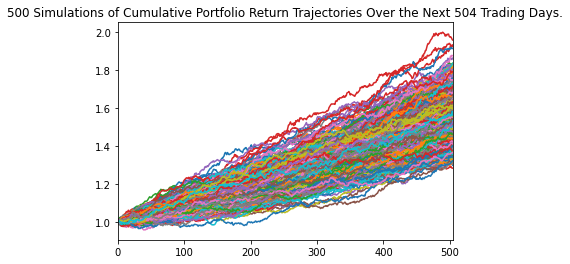

In [98]:
line_plot_low=MC_low_vol.plot_simulation()

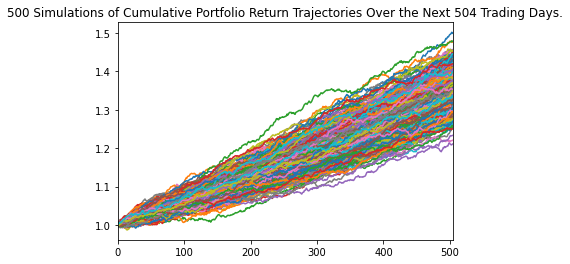

In [116]:
line_plot_high=MC_high_vol.plot_simulation()

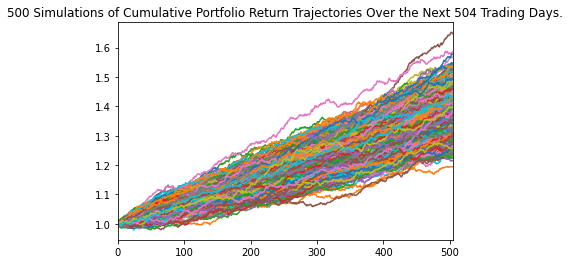

In [117]:
line_plot_rand=MC_rand_port.plot_simulation()

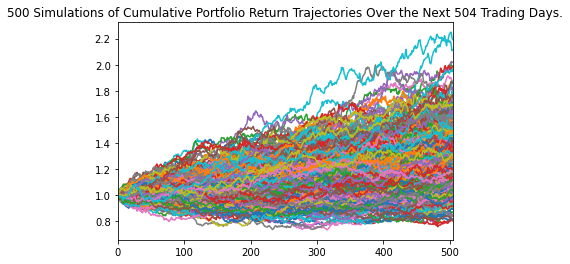

In [118]:
line_plot_index=MC_index_port.plot_simulation()